# Multi-class Classification



## 0. Preliminaries

In [1]:
# Import statements
import torch
import torch.nn as nn
from torch.nn import functional as f

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_classification, make_gaussian_quantiles
from sklearn.model_selection import train_test_split

from helper_functions import scatter_2D_class, plot_loss, accuracy_fn
from models import MultiClassificationModelV0, train_step_multi_classification, test_step_multi_classification

In [2]:
# Hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

Device is cpu


## 1. Construct, format, split and visualize data

In [4]:
# Create data
X, y = make_blobs(n_samples = 1000,
                 n_features = NUM_FEATURES,
                 centers = NUM_CLASSES,
                 cluster_std = 1.5,
                 random_state = RANDOM_SEED)


# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)    # float32 decimal digit
y = torch.from_numpy(y).type(torch.ByteTensor) # unsigned 8-bit integer

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_SEED)

In [5]:
# Move data to device (GPU or CPU) for device agnostic code

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

torch.Size([1000, 2]) torch.Size([1000]) torch.float32 torch.uint8


(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1], dtype=torch.uint8))

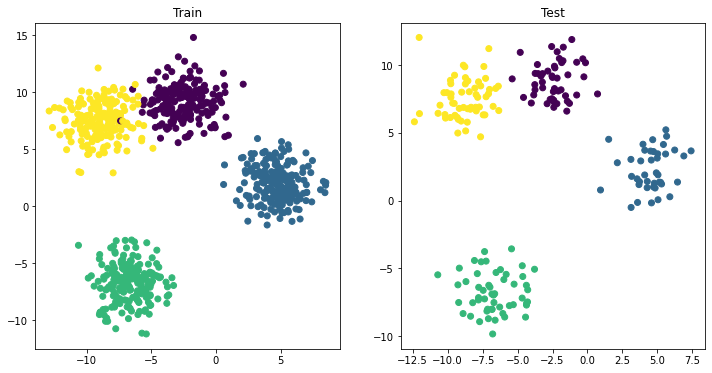

In [6]:
# Plot data and show a few samples

scatter_2D_class(train_data = X_train.to('cpu'),
              train_labels = y_train.to('cpu'),
              test_data = X_test.to('cpu'),
              test_labels = y_test.to('cpu'))

print(X.shape, y.shape, X.dtype, y.dtype)

X[:5], y[:5]

## 2. Define model, loss and optimizer

Note: Model `MultiClassificationModelV0` defined in models.py

In [7]:
# Instantiate model

model0 = MultiClassificationModelV0(input_features=NUM_FEATURES,
                                   output_features=NUM_CLASSES,
                                   hidden_units=8,
                                   nonlin=None).to(device)

model0

MultiClassificationModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Identity()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Identity()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:
# Create Loss function and optimizer

loss_fn = nn.CrossEntropyLoss() # for multi-class classification

optimizer = torch.optim.SGD(params=model0.parameters(),
                           lr=0.01)

## 3. Make predictions with untrained model

In [9]:
model0.eval()

with torch.inference_mode():
    y_logits = model0(X_test)
    
y_prob = f.softmax(y_logits,dim=1) # convert logits to prediction probabilities
y_pred = torch.argmax(y_prob,dim=1) # find location of max after softmax

loss_untrained = loss_fn(y_logits, y_test)

acc_untrained = accuracy_fn(y_pred, y_test)

In [10]:
print(f"Untrained Model - Loss: {loss_untrained.item():.4f} | Accuracy: {acc_untrained.item():.4f}")

Untrained Model - Loss: 2.8966 | Accuracy: 0.0000


In [11]:
#y_prob.shape, y_prob[:3]

In [12]:
#y_pred.shape, y_pred[:3]

## 4. Train model

In [13]:
# Set up seeds for reproducability.
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Move data to device - device agnostic code.


epochs = 500
eval_freq = 10

epoch_count = []
loss_count = []
accuracy_count = []
test_loss_count = []
test_accuracy_count = []

for epoch in range(epochs):
    
    loss, acc = train_step_multi_classification(data = X_train, 
                                                labels = y_train, 
                                                model = model0, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
    
    if epoch % eval_freq == 0:
        
        test_loss, test_acc = test_step_multi_classification(data = X_test, 
                                                             labels = y_test, 
                                                             model = model0, 
                                                             loss_fn = loss_fn)
        
        epoch_count.append(epoch)
        loss_count.append(loss.item())
        accuracy_count.append(acc)
        test_loss_count.append(test_loss.item())
        test_accuracy_count.append(test_acc)
        
        print(f"Epoch: {epoch:4d} | Loss: {loss:.4f} - Acc: {acc:.3f} | Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.3f}")

Epoch:    0 | Loss: 2.9147 - Acc: 0.000 | Test Loss: 2.3498 - Test Acc: 0.035
Epoch:   10 | Loss: 0.8314 - Acc: 0.739 | Test Loss: 0.7718 - Test Acc: 0.745
Epoch:   20 | Loss: 0.5829 - Acc: 0.971 | Test Loss: 0.5576 - Test Acc: 0.970
Epoch:   30 | Loss: 0.4579 - Acc: 0.989 | Test Loss: 0.4431 - Test Acc: 0.990
Epoch:   40 | Loss: 0.3738 - Acc: 0.989 | Test Loss: 0.3640 - Test Acc: 0.990
Epoch:   50 | Loss: 0.3132 - Acc: 0.990 | Test Loss: 0.3063 - Test Acc: 0.990
Epoch:   60 | Loss: 0.2682 - Acc: 0.990 | Test Loss: 0.2628 - Test Acc: 0.990
Epoch:   70 | Loss: 0.2338 - Acc: 0.990 | Test Loss: 0.2294 - Test Acc: 0.990
Epoch:   80 | Loss: 0.2070 - Acc: 0.990 | Test Loss: 0.2030 - Test Acc: 0.990
Epoch:   90 | Loss: 0.1856 - Acc: 0.990 | Test Loss: 0.1818 - Test Acc: 0.990
Epoch:  100 | Loss: 0.1683 - Acc: 0.989 | Test Loss: 0.1645 - Test Acc: 0.990
Epoch:  110 | Loss: 0.1540 - Acc: 0.989 | Test Loss: 0.1501 - Test Acc: 0.990
Epoch:  120 | Loss: 0.1420 - Acc: 0.989 | Test Loss: 0.1380 - Te

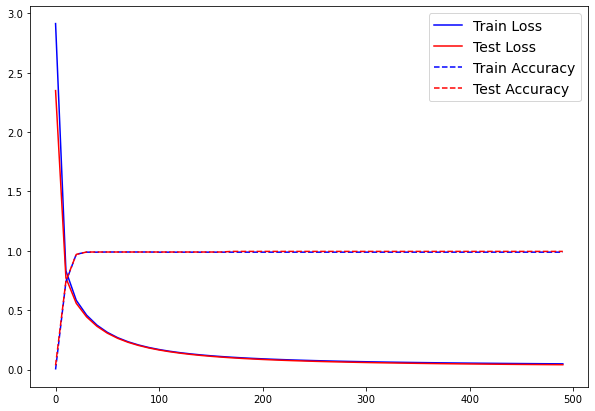

In [14]:
# Plot learning curves during training.

plot_loss(epoch=epoch_count, 
          loss=loss_count, 
          test_loss=test_loss_count,
          acc=accuracy_count,
          test_acc=test_accuracy_count)